In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
watts2_glove6b50dtxt_path = kagglehub.dataset_download('watts2/glove6b50dtxt')
danielwillgeorge_glove6b100dtxt_path = kagglehub.dataset_download('danielwillgeorge/glove6b100dtxt')
sbhatti_financial_sentiment_analysis_path = kagglehub.dataset_download('sbhatti/financial-sentiment-analysis')
antobenedetti_finance_news_sentiments_path = kagglehub.dataset_download('antobenedetti/finance-news-sentiments')

print('Data source import complete.')


100%|██████████| 67.7M/67.7M [00:00<00:00, 90.9MB/s]

Extracting files...


Using Colab cache for faster access to the 'glove6b100dtxt' dataset.


100%|██████████| 276k/276k [00:00<00:00, 76.5MB/s]

Extracting files...


100%|██████████| 1.46M/1.46M [00:00<00:00, 90.9MB/s]

Extracting files...
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [3]:
! pip install contractions emoji unidecode langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.0 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=731021e37cebfa8858d0a8cb6f06e6e9f4889b095064fee0766bd20d6076fb1b
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
import re
import json
import random
import time

import nltk
import spacy
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import contractions
from unidecode import unidecode
import emoji

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
# Run this first (takes 2-3 minutes)
!pip install transformers datasets accelerate torch sentencepiece

In [6]:
import os

df_fpb = pd.read_csv(os.path.join(sbhatti_financial_sentiment_analysis_path, "data.csv"))
df_ext = pd.read_csv(os.path.join(antobenedetti_finance_news_sentiments_path, "dataset.csv"))
df_ext = df_ext.rename(columns={'text': 'Sentence', 'sentiment': 'Sentiment'})

In [7]:
df = pd.concat([df_fpb, df_ext], ignore_index=True)
print('Shape of the dataset:',df.shape)
print('\nColumns in the dataset:',df.columns)
print('\nData types:\n',df.dtypes)
print('\nMissing values in the dataset:\n',df.isna().sum())
print('\nDuplicate rows in the dataset:',df.duplicated().sum())


Shape of the dataset: (38425, 2)

Columns in the dataset: Index(['Sentence', 'Sentiment'], dtype='object')

Data types:
 Sentence     object
Sentiment    object
dtype: object

Missing values in the dataset:
 Sentence     14
Sentiment     0
dtype: int64

Duplicate rows in the dataset: 4204


In [8]:
df.describe()

,Sentence,Sentiment
count,38411,38425
unique,33696,3
top,News Highlights : Top Energy News of the Day #...,neutral
freq,15,13991


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.dropna(inplace=True)

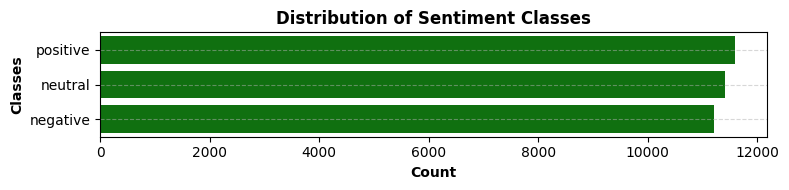

In [11]:

label_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8,2))
sns.barplot(x=label_counts.values, y=label_counts.index, color='green')

# Add labels and title
plt.title("Distribution of Sentiment Classes", weight='bold')
plt.xlabel("Count", weight='bold')
plt.ylabel("Classes", weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [12]:
print(df['Sentiment'].value_counts())

Sentiment
positive    11592
neutral     11411
negative    11215
Name: count, dtype: int64


In [13]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42

def detect_language(text):
    """
    Attempts to detect the language of a given text.
    Returns 'en' if English, or the detected language code otherwise.
    Returns 'error' if detection fails (e.g., text is too short or NaN).
    """
    if pd.isna(text) or not isinstance(text, str) or len(text.strip()) < 5:
        return 'error'
    try:
        # Detect returns the language code (e.g., 'en', 'es', 'fr')
        return detect(text)
    except Exception:
        # Catch exceptions if the text is too ambiguous or short for detection
        return 'error'

def clean_non_english_rows(df, text_column='text', target_language='en'):
    """
    Detects and removes rows where the specified text column is not the target language.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing the text.
        target_language (str): The language code to keep (default is 'en' for English).

    Returns:
        pd.DataFrame: The DataFrame with non-target language rows removed.
    """
    print(f"Starting language detection on column '{text_column}'...")
    initial_row_count = len(df)
    start_time = time.time()

    # Apply the detection function to the text column
    # Using 'apply' can be slow, but is effective for this task
    df['detected_lang'] = df[text_column].apply(detect_language)

    # Filter for rows that are NOT the target language or resulted in an error
    # We remove 'error' rows as they cannot be reliably classified
    non_english_mask = (df['detected_lang'] != target_language)

    # Get the count of rows to be removed
    non_english_count = non_english_mask.sum()

    print("-" * 40)
    print(f"Total initial rows: {initial_row_count}")
    print(f"Non-{target_language} rows detected: {non_english_count}")

    if non_english_count > 0:
        # Create the cleaned DataFrame by inverting the mask
        df_cleaned = df[~non_english_mask].drop(columns=['detected_lang'])
        final_row_count = len(df_cleaned)
        print(f"Rows removed: {initial_row_count - final_row_count}")
        print(f"Total remaining rows: {final_row_count}")
        print(f"Detection and cleaning completed in {time.time() - start_time:.2f} seconds.")
        print("-" * 40)
        return df_cleaned
    else:
        print("No non-target language rows found. Returning original DataFrame.")
        print("-" * 40)
        return df.drop(columns=['detected_lang'])


# =================================================================
# 1. SETUP: Create a sample DataFrame for demonstration
# =================================================================
data1 = {
    'text': [
        "This is an English sentence for sentiment analysis.",
        "El perro corre rápido por el parque.", # Spanish (es)
        "I love this new product, it's amazing!",
        "Das ist ein deutscher Satz.", # German (de)
        "Very good movie, highly recommend.",
        "Ce n'est pas facile.", # French (fr)
        np.nan, # NaN value
        "C'est la vie" # French or English (depending on detector)
    ],
    'sentiment': [1, 0, 1, 0, 1, 0, 0, 1]
}

df_raw = pd.DataFrame(data1)
print("--- Original DataFrame (First 8 Rows) ---")
print(df_raw.head(8))
print("\n" + "="*50 + "\n")


# =================================================================
# 2. EXECUTION: Run the cleaning function
# =================================================================
# NOTE: The 'vocab' object mentioned in your previous context is not needed here,
# as this is a data cleaning step done on the DataFrame itself.
df = clean_non_english_rows(df.copy(), text_column='Sentence')


# =================================================================
# 3. RESULT: Display the cleaned DataFrame
# =================================================================
print("\n" + "="*50)
print("--- Cleaned DataFrame (Only English Rows Remaining) ---")
print(df)
print(f"\nFinal Shape: {df.shape}")

--- Original DataFrame (First 8 Rows) ---
                                                text  sentiment
0  This is an English sentence for sentiment anal...          1
1               El perro corre rápido por el parque.          0
2             I love this new product, it's amazing!          1
3                        Das ist ein deutscher Satz.          0
4                 Very good movie, highly recommend.          1
5                               Ce n'est pas facile.          0
6                                                NaN          0
7                                       C'est la vie          1


Starting language detection on column 'Sentence'...
----------------------------------------
Total initial rows: 34218
Non-en rows detected: 1981
Rows removed: 1981
Total remaining rows: 32237
Detection and cleaning completed in 180.31 seconds.
----------------------------------------

--- Cleaned DataFrame (Only English Rows Remaining) ---
                                     

In [14]:


df['text_length'] = df['Sentence'].astype(str).apply(len)
df['word_count'] = df['Sentence'].astype(str).apply(lambda x: len(x.split()))

print(df[['text_length','word_count']].describe())


        text_length    word_count
count  32237.000000  32237.000000
mean      97.878028     16.461674
std       56.100610      9.580783
min        7.000000      1.000000
25%       60.000000     10.000000
50%       83.000000     14.000000
75%      116.000000     20.000000
max      315.000000     81.000000


In [15]:
url_pattern = r'http\S+|www.\S+'
url_rows = df['Sentence'].str.contains(url_pattern, regex=True)
print(f"texts containing URLs: {url_rows.sum()} / {len(df)} ({url_rows.mean()*100:.2f}%)")

obfuscation_rows = df['Sentence'].str.contains(r'[@$0-9]', regex=True)
print(f"Comments with obfuscation-like symbols (0,1,@,$): {obfuscation_rows.sum()} / {len(df)} ({obfuscation_rows.mean()*100:.2f}%)")

mention_rows = df['Sentence'].str.contains(r'@\w+', regex=True)
print(f"Comments with @mentions: {mention_rows.sum()} / {len(df)} ({mention_rows.mean()*100:.2f}%)")

hashtag_rows = df['Sentence'].str.contains(r'#\w+', regex=True)
print(f"Comments with hashtags: {hashtag_rows.sum()} / {len(df)} ({hashtag_rows.mean()*100:.2f}%)")


non_ascii_rows = df['Sentence'].apply(lambda x: any(ord(c) > 127 for c in str(x)))
print(f"Comments with non-ASCII characters: {non_ascii_rows.sum()} / {len(df)} ({non_ascii_rows.mean()*100:.2f}%)")


texts containing URLs: 277 / 32237 (0.86%)
Comments with obfuscation-like symbols (0,1,@,$): 15018 / 32237 (46.59%)
Comments with @mentions: 609 / 32237 (1.89%)
Comments with hashtags: 1480 / 32237 (4.59%)
Comments with non-ASCII characters: 4755 / 32237 (14.75%)


In [16]:
df[non_ascii_rows].head()

,Sentence,Sentiment,text_length,word_count
17,According to L+ñnnen Tehtaat 's CEO Matti Karp...,neutral,151,27
82,The Brazilian unit of Finnish security solutio...,positive,215,35
164,The pulp production in Finnish Kemij+ñrvi will...,negative,110,18
176,CEO Erkki J+ñrvinen is happy with the company ...,positive,70,13
261,"Copper , lead and nickel also dropped ... HBOS...",neutral,112,23


In [17]:
def clean_financial_text(text):
    """
    Robust financial text cleaner:
      - Replaces currency symbol+amount and amount+symbol (pre-normalization)
      - Converts emojis, contractions, unicode -> ascii
      - Inserts spaces between letters/digits created by unidecode (EUR89 -> EUR 89)
      - Replaces word-form currencies + amounts and standalone currency words
      - Replaces percents and numeric tokens with <NUM>, and final cleanup
    """

    if text is None:
        return ""

    s = str(text).lower()

    # Basic cleaning only
    s = re.sub(r'http\S+|www\.\S+', ' <URL> ', s)
    s = re.sub(r'@\w+', ' <TICKER> ', s)
    s = re.sub(r'#(\w+)', r'\1', s)

    # Keep numbers as they might be important (percentages, amounts)
    # Replace specific patterns but keep the numbers
    s = re.sub(r'\b\d+%\b', ' <PERCENT> ', s)
    s = re.sub(r'[\$€£]\s*\d+', ' <MONEY> ', s)

    # Remove punctuation but keep sentence structure
    s = re.sub(r'[^\w\s<>]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [18]:
examples = [
    "Tesla stock up 5% to $950 after strong Q4 earnings 💰",
    "BMW shares fell 3.2% to €89.50 amid supply chain issues.",
    "Tata Motors gained ₹15 after govt. EV subsidy update.",
    "Sony profits hit ¥10 billion as PS5 sales surge!",
    "Samsung lost 2% in ₩ due to memory chip slump."
]

for e in examples:
    print(e, "→", clean_financial_text(e))


Tesla stock up 5% to $950 after strong Q4 earnings 💰 → tesla stock up 5 to <MONEY> after strong q4 earnings
BMW shares fell 3.2% to €89.50 amid supply chain issues. → bmw shares fell 3 2 to <MONEY> 50 amid supply chain issues
Tata Motors gained ₹15 after govt. EV subsidy update. → tata motors gained 15 after govt ev subsidy update
Sony profits hit ¥10 billion as PS5 sales surge! → sony profits hit 10 billion as ps5 sales surge
Samsung lost 2% in ₩ due to memory chip slump. → samsung lost 2 in due to memory chip slump


In [19]:
df['clean_text'] = df['Sentence'].apply(clean_financial_text)

In [20]:
def tokenize_text(text):
    """Tokenizes text into individual words."""
    return nltk.word_tokenize(text)

df['tokenized'] = df['clean_text'].apply(tokenize_text)

print("Before tokenization:")
print(df['clean_text'].iloc[0])
print("\nAfter tokenization:")
print(df['tokenized'].iloc[0])


stop_words = set(stopwords.words('english'))

minimal_stopwords = set([
    'a', 'an', 'the', 'and', 'or', 'of', 'at', 'by', 'for', 'with',
    'from', 'to', 'in', 'on', 'is', 'are', 'was', 'were', 'been', 'be',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
    'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those'
])
def remove_stopwords(tokens):
    """Remove only truly useless stopwords"""
    return [t for t in tokens if t.lower() not in minimal_stopwords and len(t) > 1]

df['no_stopwords'] = df['tokenized'].apply(remove_stopwords)

# Show before and after
print("Before stopword removal:")
print(df['tokenized'].iloc[0])
print("\nAfter stopword removal:")
print(df['no_stopwords'].iloc[0])



# lemmatizer = WordNetLemmatizer()

# Commented out lemmatization because it was not improving the result and instead actually lowering the vocabulary size

# def get_wordnet_pos(treebank_tag):
#     """
#     Converts NLTK POS tags (from pos_tag) to WordNet POS tags.
#     Default is noun if tag not found.
#     """
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN



# def lemmatize_with_pos(tokens):
#     """
#     Lemmatizes tokens using their POS tags for improved accuracy.
#     """
#     pos_tags = nltk.pos_tag(tokens)
#     lemmatized = [
#         lemmatizer.lemmatize(word, get_wordnet_pos(tag))
#         for word, tag in pos_tags
#     ]
#     return lemmatized



# tqdm.pandas()

# df['pos_lemmatized'] = df['no_stopwords'].progress_apply(lemmatize_with_pos)

# print("Before pos_lemmatization:")
# print(df['no_stopwords'].iloc[0])
# print("\nAfter pos_lemmatization:")
# print(df['pos_lemmatized'].iloc[0])




Before tokenization:
the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model

After tokenization:
['the', 'geosolutions', 'technology', 'will', 'leverage', 'benefon', 's', 'gps', 'solutions', 'by', 'providing', 'location', 'based', 'search', 'technology', 'a', 'communities', 'platform', 'location', 'relevant', 'multimedia', 'content', 'and', 'a', 'new', 'and', 'powerful', 'commercial', 'model']
Before stopword removal:
['the', 'geosolutions', 'technology', 'will', 'leverage', 'benefon', 's', 'gps', 'solutions', 'by', 'providing', 'location', 'based', 'search', 'technology', 'a', 'communities', 'platform', 'location', 'relevant', 'multimedia', 'content', 'and', 'a', 'new', 'and', 'powerful', 'commercial', 'model']

After stopword removal:
['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solutions', 'providing', 'location

In [21]:

df['processed_text'] = df['no_stopwords'].apply(lambda tokens: " ".join(tokens))


Length statistics:
Mean: 12.3
Median: 11.0
75th percentile: 15.0
90th percentile: 21.0
95th percentile: 27.0
99th percentile: 34.0
Max: 48


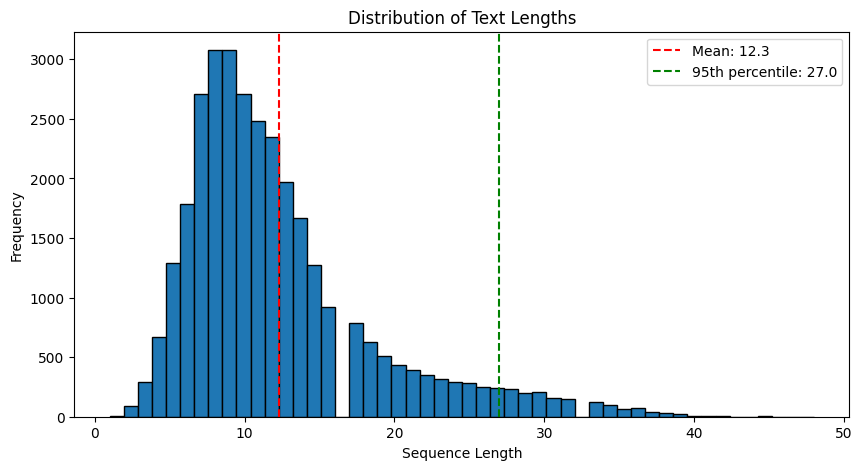

In [22]:
# Let's check the distribution
text_lengths = df['no_stopwords'].apply(len)
print(f"Length statistics:")
print(f"Mean: {text_lengths.mean():.1f}")
print(f"Median: {text_lengths.median():.1f}")
print(f"75th percentile: {text_lengths.quantile(0.75):.1f}")
print(f"90th percentile: {text_lengths.quantile(0.90):.1f}")
print(f"95th percentile: {text_lengths.quantile(0.95):.1f}")
print(f"99th percentile: {text_lengths.quantile(0.99):.1f}")
print(f"Max: {text_lengths.max()}")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.1f}')
plt.axvline(text_lengths.quantile(0.95), color='green', linestyle='--', label=f'95th percentile: {text_lengths.quantile(0.95):.1f}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.show()

In [23]:

class Vocabulary:
    def __init__(self, min_freq):
        """
        min_freq: minimum frequency for a word to be included in vocab
        Words appearing less than min_freq times will be treated as <UNK>
        """
        self.min_freq = min_freq
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.word_freq = Counter()

    def build_vocabulary(self, texts):
        """
        texts: list of tokenized texts (each text is a list of words)
        Example: [['stock', 'price', 'rise'], ['market', 'fall']]
        """
        # Count all words
        for tokens in texts:
            self.word_freq.update(tokens)

        # Add words that appear at least min_freq times
        idx = 2  # Start from 2 (0 and 1 are reserved)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)} words")
        # print(f"Words filtered out (freq < {self.min_freq}): {sum(1 for f in self.word_freq.values() if f < self.min_freq)}")

    def encode(self, tokens):
        """Convert list of tokens to list of indices"""
        return [self.word2idx.get(word, 1) for word in tokens]  # 1 is <UNK>

    def decode(self, indices):
        """Convert list of indices back to tokens"""
        return [self.idx2word.get(idx, "<UNK>") for idx in indices]

In [24]:

# Create vocabulary object
vocab = Vocabulary(min_freq=5)

# Build from your processed text (convert strings back to lists)
vocab.build_vocabulary(df['no_stopwords'].tolist())


Vocabulary size: 9098 words


In [25]:

# Let's test it!
sample_text = df['no_stopwords'].iloc[0]
print(f"Original tokens: {sample_text[:10]}")  # First 10 words

encoded = vocab.encode(sample_text)
print(f"Encoded: {encoded[:10]}")

decoded = vocab.decode(encoded[:10])
print(f"Decoded back: {decoded}")

Original tokens: ['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solutions', 'providing', 'location', 'based', 'search']
Encoded: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Decoded back: ['<UNK>', 'technology', 'leverage', 'benefon', 'gps', 'solutions', 'providing', 'location', 'based', 'search']


In [26]:
# Remove empty texts (this is important!)
df = df[df['no_stopwords'].apply(len) > 0].reset_index(drop=True)
print(f"Rows after removing empty texts: {len(df)}")

# Encode labels: positive=2, neutral=1, negative=0
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['Sentiment'].map(label_map)

print("\nLabel distribution:")
print(df['label'].value_counts().sort_index())

Rows after removing empty texts: 32237

Label distribution:
label
0    10568
1    10770
2    10899
Name: count, dtype: int64


In [27]:
def pad_sequence(sequence, max_len):
    """
    Pads or truncates sequence to max_len
    - If too short: add 0s at the end
    - If too long: cut it to max_len
    """
    if len(sequence) < max_len:
        # Pad with zeros
        return sequence + [0] * (max_len - len(sequence))
    else:
        # Truncate
        return sequence[:max_len]

# Encode all texts
df['encoded'] = df['no_stopwords'].apply(vocab.encode)

df['true_length'] = df['encoded'].apply(len)

# Let's use max_len based on your data
MAX_LENGTH = 48

df['padded'] = df['encoded'].apply(lambda x: pad_sequence(x, MAX_LENGTH))

# Verify
print(f"All sequences now have length: {df['padded'].apply(len).unique()}")
print(f"\nExample padded sequence:")
print(df['padded'].iloc[0])

All sequences now have length: [79]

Example padded sequence:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 11, 12, 8, 13, 1, 14, 15, 16, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
df.head()

,Sentence,Sentiment,text_length,word_count,clean_text,tokenized,no_stopwords,processed_text,label,encoded,true_length,padded
0,The GeoSolutions technology will leverage Bene...,positive,218,32,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 11, 12, 8, ...",21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 11, 12, 8, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,11,esi on lows down <MONEY> 50 to <MONEY> 50 bk a...,"[esi, on, lows, down, <, MONEY, >, 50, to, <, ...","[esi, lows, down, MONEY, 50, MONEY, 50, bk, re...",esi lows down MONEY 50 MONEY 50 bk real possib...,0,"[1, 19, 20, 21, 22, 21, 22, 23, 24, 25]",10,"[1, 19, 20, 21, 22, 21, 22, 23, 24, 25, 0, 0, ..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,39,for the last quarter of 2010 componenta s net ...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ...",last quarter 2010 componenta net sales doubled...,2,"[26, 27, 28, 29, 30, 31, 32, 1, 1, 33, 34, 35,...",24,"[26, 27, 28, 29, 30, 31, 32, 1, 1, 33, 34, 35,..."
3,According to the Finnish-Russian Chamber of Co...,neutral,128,20,according to the finnish russian chamber of co...,"[according, to, the, finnish, russian, chamber...","[according, finnish, russian, chamber, commerc...",according finnish russian chamber commerce all...,1,"[45, 46, 47, 1, 48, 49, 50, 51, 52, 53, 54, 55]",12,"[45, 46, 47, 1, 48, 49, 50, 51, 52, 53, 54, 55..."
4,The Swedish buyout firm has sold its remaining...,neutral,135,23,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, its, remaining, ...",swedish buyout firm sold its remaining 22 perc...,1,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1, 66...",17,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1, 66..."


In [29]:
df.shape

(32237, 12)

In [30]:


from torch.utils.data import Dataset # You should ensure this is imported

class SentimentDataset(Dataset):
    """
    PyTorch Dataset for sentiment analysis
    """
    def __init__(self, texts, labels, lengths):
        """
        texts: list of padded sequences (list of lists)
        labels: list of label integers
        """
        # FIX: Change dtype from object to int32. This assumes all sequences
        # in 'texts' have the same length (which they should, as they are padded).
        self.texts = np.array(texts, dtype=np.int32)
        self.labels = np.array(labels, dtype=np.int32)
        self.lengths = np.array(lengths, dtype=np.int32) # Use int32 for consistency

    # __len__ and __getitem__ can remain as they are now.
    def __len__(self):
        """Returns the number of samples"""
        return len(self.texts)

    def __getitem__(self, idx):
        # Now, self.texts[idx] will return a NumPy array of shape (BATCH_SIZE, max_len)
        # or (max_len,) for a single sample, which torch.tensor can handle.
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        length = torch.tensor(self.lengths[idx], dtype=torch.long)
        return text, label, length

# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Create datasets
train_dataset = SentimentDataset(
    train_df['padded'].tolist(),
    train_df['label'].tolist(),
    train_df['true_length'].tolist()
)

val_dataset = SentimentDataset(
    val_df['padded'].tolist(),
    val_df['label'].tolist(),
    val_df['true_length'].tolist()
)

test_dataset = SentimentDataset(
    test_df['padded'].tolist(),
    test_df['label'].tolist(),
    test_df['true_length'].tolist()
)

# Create dataloaders (these handle batching)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train size: 25789
Validation size: 3224
Test size: 3224

Number of batches - Train: 806, Val: 101, Test: 101


In [31]:

# embedding layer
embedding_dim = 50
vocab_size = len(vocab.word2idx)

embedding_layer = nn.Embedding(
    num_embeddings=vocab_size,  # Total words in vocabulary
    embedding_dim=embedding_dim,  # Vector size for each word
    padding_idx=0  # Tell it that 0 is padding (don't learn for it)
)

print(f"Embedding layer created!")
print(f"Parameters shape: {embedding_layer.weight.shape}")

Embedding layer created!
Parameters shape: torch.Size([9098, 50])


# BiLSTM-Attention

In [ ]:
print("\n" + "="*80)
print("ARCHITECTURE: BiLSTM + ATTENTION MECHANISM")
print("="*80 + "\n")

# ============================================================
# STEP 1: Define Attention Layer
# ============================================================
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        """
        hidden_dim: Size of BiLSTM hidden state (256 in your case: 128*2)
        """
        super(Attention, self).__init__()

        # This layer learns to score each hidden state
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output, lengths):
        """
        lstm_output: [batch_size, seq_len, hidden_dim] - All BiLSTM outputs
        lengths: [batch_size] - Actual lengths (to mask padding)

        Returns:
        - context: [batch_size, hidden_dim] - Weighted combination
        - attention_weights: [batch_size, seq_len] - For visualization
        """

        # Step 1: Calculate attention scores
        attention_scores = self.attention(lstm_output)  # [batch, seq_len, 1]
        attention_scores = attention_scores.squeeze(2)   # [batch, seq_len]

        # Step 2: Create mask to ignore padding
        batch_size, seq_len = attention_scores.shape
        mask = torch.arange(seq_len, device=lstm_output.device).unsqueeze(0) < lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, -1e18)

        # Step 3: Convert to probabilities
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch, seq_len]

        # Step 4: Weighted sum of hidden states
        context = torch.bmm(
            attention_weights.unsqueeze(1),  # [batch, 1, seq_len]
            lstm_output                       # [batch, seq_len, hidden_dim]
        ).squeeze(1)  # [batch, hidden_dim]

        return context, attention_weights


# ============================================================
# STEP 2: Define BiLSTM + Attention Model
# ============================================================
class BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.3):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # NEW: Attention layer
        self.attention = Attention(hidden_dim * 2)

        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text, lengths):
        # Embed
        embedded = self.embedding(text)

        # Pack and pass through BiLSTM
        packed_embedded = rnn_utils.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack to get all outputs (needed for attention)
        lstm_output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Apply Attention
        context, attention_weights = self.attention(lstm_output, lengths)

        # Layer norm, dropout, classification
        context = self.norm(context)
        context = self.dropout(context)
        output = self.fc(context)

        return output, attention_weights


ARCHITECTURE: BiLSTM + ATTENTION MECHANISM



In [ ]:
SEED = 1  # You can choose any integer

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
# ============================================================
# STEP 3: Training and Evaluation Functions
# ============================================================
def train_epoch_attention(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for text, labels, lengths in tqdm(dataloader, desc="Training"):
        text = text.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        predictions, _ = model(text, lengths)  # Ignore attention weights during training

        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return epoch_loss / len(dataloader), correct / total


def evaluate_attention(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for text, labels, lengths in tqdm(dataloader, desc="Evaluating"):
            text = text.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            predictions, _ = model(text, lengths)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return epoch_loss / len(dataloader), correct / total


# ============================================================
# STEP 4: Create and Train the Model
# ============================================================
print("Creating BiLSTM + Attention model...")

# Use same hyperparameters as BiLSTM for fair comparison
model_attention = BiLSTM_Attention(
    vocab_size=len(vocab.word2idx),
    embedding_dim=50,
    hidden_dim=100,
    output_dim=3,
    n_layers=1,
    dropout=0.3
)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_attention = model_attention.to(device)

print(model_attention)
print(f"\nTotal parameters: {sum(p.numel() for p in model_attention.parameters()):,}")

# Optimizer and loss
criterion_attention = nn.CrossEntropyLoss()
optimizer_attention = torch.optim.Adam(model_attention.parameters(), lr=0.002, weight_decay=1e-4)#weight_decay=1e-3

# Training loop with early stopping
N_EPOCHS_ATT = 10
best_val_acc_att = 0
patience = 3
patience_counter = 0

train_losses_att, val_losses_att = [], []
train_accs_att, val_accs_att = [], []

print("\nStarting training...\n")

for epoch in range(N_EPOCHS_ATT):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{N_EPOCHS_ATT}")
    print(f"{'='*60}")

    train_loss, train_acc = train_epoch_attention(model_attention, train_loader, criterion_attention, optimizer_attention, device)
    val_loss, val_acc = evaluate_attention(model_attention, val_loader, criterion_attention, device)

    train_losses_att.append(train_loss)
    val_losses_att.append(val_loss)
    train_accs_att.append(train_acc)
    val_accs_att.append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print(f"Gap: {(train_acc - val_acc)*100:.2f}%")

    # Early stopping
    if val_acc > best_val_acc_att:
        best_val_acc_att = val_acc
        patience_counter = 0
        torch.save(model_attention.state_dict(), 'best_bilstm_attention_model.pt')
        print(f"✓ Saved! (Val Acc: {val_acc*100:.2f}%)")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("\n🛑 Early stopping triggered!")
            break

print(f"\n{'='*60}")
print(f"Training Complete! Best Val Acc: {best_val_acc_att*100:.2f}%")
print(f"{'='*60}")

Creating BiLSTM + Attention model...
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


BiLSTM_Attention(
  (embedding): Embedding(9098, 50, padding_idx=0)
  (lstm): LSTM(50, 100, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=200, out_features=1, bias=True)
  )
  (norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=3, bias=True)
)

Total parameters: 577,704

Starting training...


Epoch 1/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 1.0052 | Train Acc: 48.42%
Val Loss: 0.8574 | Val Acc: 59.52%
Gap: -11.10%
✓ Saved! (Val Acc: 59.52%)

Epoch 2/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.7864 | Train Acc: 64.17%
Val Loss: 0.7412 | Val Acc: 66.90%
Gap: -2.73%
✓ Saved! (Val Acc: 66.90%)

Epoch 3/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6735 | Train Acc: 70.29%
Val Loss: 0.7443 | Val Acc: 65.94%
Gap: 4.35%
No improvement (1/3)

Epoch 4/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6018 | Train Acc: 73.77%
Val Loss: 0.7409 | Val Acc: 67.03%
Gap: 6.74%
✓ Saved! (Val Acc: 67.03%)

Epoch 5/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.5352 | Train Acc: 76.72%
Val Loss: 0.7871 | Val Acc: 66.97%
Gap: 9.75%
No improvement (1/3)

Epoch 6/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.4659 | Train Acc: 79.64%
Val Loss: 0.8342 | Val Acc: 65.38%
Gap: 14.25%
No improvement (2/3)

Epoch 7/10


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.3970 | Train Acc: 82.99%
Val Loss: 0.9729 | Val Acc: 64.49%
Gap: 18.51%
No improvement (3/3)

🛑 Early stopping triggered!

Training Complete! Best Val Acc: 67.03%


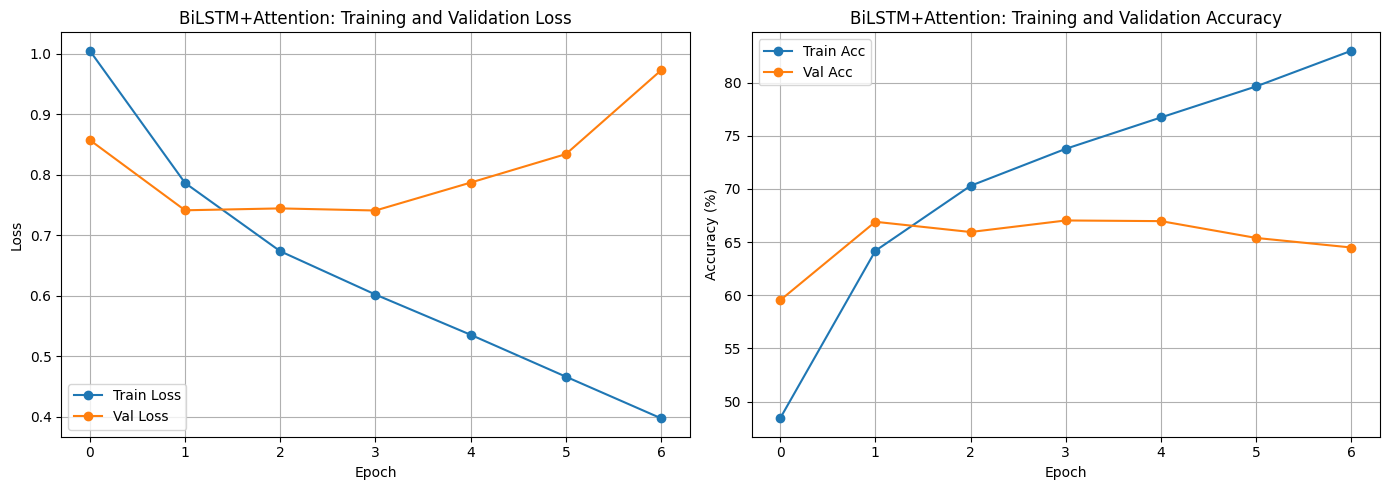

In [ ]:
# ============================================================
# STEP 5: Plot Results
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses_att, label='Train Loss', marker='o')
ax1.plot(val_losses_att, label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('BiLSTM+Attention: Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot([acc*100 for acc in train_accs_att], label='Train Acc', marker='o')
ax2.plot([acc*100 for acc in val_accs_att], label='Val Acc', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('BiLSTM+Attention: Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# STEP 6: Evaluate on Test Set
# ============================================================
print("\nEvaluating on Test Set...")

model_attention.load_state_dict(torch.load('best_bilstm_attention_model.pt'))
model_attention.to(device)
model_attention.eval()

all_preds_att = []
all_labels_att = []
all_probs_att = []

with torch.no_grad():
    for text, labels, lengths in tqdm(test_loader, desc="Testing"):
        text = text.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        predictions, _ = model_attention(text, lengths)

        _, predicted_classes = torch.max(predictions, 1)
        all_preds_att.extend(predicted_classes.cpu().numpy())
        all_labels_att.extend(labels.cpu().numpy())

        probabilities = torch.softmax(predictions, dim=1)
        all_probs_att.extend(probabilities.cpu().numpy())

all_preds_att = np.array(all_preds_att)
all_labels_att = np.array(all_labels_att)
all_probs_att = np.array(all_probs_att)

# Classification Report
print("\n" + "="*60)
print("BiLSTM + Attention: Classification Report")
print("="*60)
print(classification_report(all_labels_att, all_preds_att, target_names=['negative', 'neutral', 'positive']))

# ROC AUC
roc_auc_att = roc_auc_score(all_labels_att, all_probs_att, multi_class='ovr', average='macro')
print(f"\nROC AUC Score: {roc_auc_att:.4f}")
print("="*60)


Evaluating on Test Set...


Testing:   0%|          | 0/101 [00:00<?, ?it/s]


BiLSTM + Attention: Classification Report
              precision    recall  f1-score   support

    negative       0.63      0.65      0.64      1057
     neutral       0.73      0.76      0.74      1077
    positive       0.66      0.61      0.63      1090

    accuracy                           0.67      3224
   macro avg       0.67      0.67      0.67      3224
weighted avg       0.67      0.67      0.67      3224


ROC AUC Score: 0.8527


# BiLSTM-Attention with GloVe

In [ ]:
# ============================================================
# LOAD GLOVE EMBEDDINGS
# ============================================================

def load_glove_embeddings(glove_file, vocab, embedding_dim):
    """
    Load GloVe embeddings and create embedding matrix for our vocabulary

    vocab: Your Vocabulary object
    embedding_dim: 100 (must match GloVe file)

    Returns: numpy array of shape [vocab_size, embedding_dim]
    """
    print("Loading GloVe embeddings...")

    # Load GloVe into dictionary
    glove_embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector

    print(f"Loaded {len(glove_embeddings)} GloVe vectors")

    # Create embedding matrix for OUR vocabulary
    vocab_size = len(vocab.word2idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    found = 0
    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
            found += 1
        else:
            # Word not in GloVe: initialize randomly (small values)
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

    print(f"Found {found}/{vocab_size} words in GloVe ({found/vocab_size*100:.1f}%) Kishan)")

    return embedding_matrix

# Load GloVe
GLOVE_FILE = os.path.join(danielwillgeorge_glove6b100dtxt_path, 'glove.6B.100d.txt')
embedding_matrix = load_glove_embeddings(GLOVE_FILE, vocab, 100)

# Convert to PyTorch tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Loading GloVe embeddings...
Loaded 400000 GloVe vectors
Found 8685/9098 words in GloVe (95.5%) Kishan)
Embedding matrix shape: torch.Size([9098, 100])


In [ ]:
# ============================================================
# BiLSTM + ATTENTION WITH PRETRAINED EMBEDDINGS
# ============================================================

class BiLSTM_Attention_Pretrained(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, dropout, pretrained_embeddings=None):
        super(BiLSTM_Attention_Pretrained, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Load pretrained embeddings if provided
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            print("✓ Loaded pretrained GloVe embeddings")

        # OPTIONAL: Fine-tune embeddings or freeze them
        # self.embedding.weight.requires_grad = False  # Freeze (don't train)
        # OR
        self.embedding.weight.requires_grad = True  # Fine-tune (train)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.attention = Attention(hidden_dim * 2)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)

        packed_embedded = rnn_utils.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # print(f"Packed output type: {type(packed_output)}")
        # print(f"Packed data size: {packed_output.data.size()}")
        lstm_output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)


        context, attention_weights = self.attention(lstm_output, lengths)
        context = self.norm(context)
        context = self.dropout(context)
        output = self.fc(context)

        return output, attention_weights




In [ ]:
SEED = 1  # You can choose any integer

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
# Create model with pretrained embeddings
print("Creating BiLSTM + Attention with GloVe embeddings...")

# BETTER HYPERPARAMETERS
EMBEDDING_DIM = 100
HIDDEN_DIM = 200
OUTPUT_DIM = 3
N_LAYERS = 1
DROPOUT = 0.3

model_glove = BiLSTM_Attention_Pretrained(
    vocab_size=len(vocab.word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    pretrained_embeddings=embedding_matrix  # ← KEY: Pass pretrained embeddings
)

model_glove = model_glove.to(device)

print(model_glove)
print(f"\nTotal parameters: {sum(p.numel() for p in model_glove.parameters()):,}")

# Optimizer with weight decay
optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=0.001, weight_decay=1e-3)
criterion_glove = nn.CrossEntropyLoss()

# Training loop
N_EPOCHS_GLOVE = 15
best_val_acc_glove = 0
patience = 3
patience_counter = 0

train_losses_glove, val_losses_glove = [], []
train_accs_glove, val_accs_glove = [], []

print("\nTraining BiLSTM+Attention with GloVe...\n")

for epoch in range(N_EPOCHS_GLOVE):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{N_EPOCHS_GLOVE}")
    print(f"{'='*60}")

    train_loss, train_acc = train_epoch_attention(model_glove, train_loader, criterion_glove, optimizer_glove, device)
    val_loss, val_acc = evaluate_attention(model_glove, val_loader, criterion_glove, device)

    train_losses_glove.append(train_loss)
    val_losses_glove.append(val_loss)
    train_accs_glove.append(train_acc)
    val_accs_glove.append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print(f"Gap: {(train_acc - val_acc)*100:.2f}%")

    if val_acc > best_val_acc_glove:
        best_val_acc_glove = val_acc
        patience_counter = 0
        torch.save(model_glove.state_dict(), 'best_bilstm_attention_glove.pt')
        print(f"✓ Saved! (Val Acc: {val_acc*100:.2f}%)")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("\n🛑 Early stopping!")
            break

print(f"\n{'='*60}")
print(f"Best Val Acc with GloVe: {best_val_acc_glove*100:.2f}%")
print(f"{'='*60}")

Creating BiLSTM + Attention with GloVe embeddings...
✓ Loaded pretrained GloVe embeddings
BiLSTM_Attention_Pretrained(
  (embedding): Embedding(9098, 100, padding_idx=0)
  (lstm): LSTM(100, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=400, out_features=1, bias=True)
  )
  (norm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=3, bias=True)
)

Total parameters: 1,395,404

Training BiLSTM+Attention with GloVe...


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.9703 | Train Acc: 52.53%
Val Loss: 0.8465 | Val Acc: 60.20%
Gap: -7.67%
✓ Saved! (Val Acc: 60.20%)

Epoch 2/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.8297 | Train Acc: 61.94%
Val Loss: 0.7978 | Val Acc: 64.21%
Gap: -2.27%
✓ Saved! (Val Acc: 64.21%)

Epoch 3/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.7774 | Train Acc: 64.88%
Val Loss: 0.8178 | Val Acc: 63.06%
Gap: 1.82%
No improvement (1/3)

Epoch 4/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.7512 | Train Acc: 66.71%
Val Loss: 0.7916 | Val Acc: 63.37%
Gap: 3.34%
No improvement (2/3)

Epoch 5/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.7240 | Train Acc: 68.54%
Val Loss: 0.7805 | Val Acc: 65.32%
Gap: 3.22%
✓ Saved! (Val Acc: 65.32%)

Epoch 6/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.7098 | Train Acc: 68.84%
Val Loss: 0.7916 | Val Acc: 64.08%
Gap: 4.75%
No improvement (1/3)

Epoch 7/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6923 | Train Acc: 69.89%
Val Loss: 0.7781 | Val Acc: 65.38%
Gap: 4.51%
✓ Saved! (Val Acc: 65.38%)

Epoch 8/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6859 | Train Acc: 70.30%
Val Loss: 0.7785 | Val Acc: 65.35%
Gap: 4.94%
No improvement (1/3)

Epoch 9/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6812 | Train Acc: 70.46%
Val Loss: 0.8021 | Val Acc: 62.84%
Gap: 7.62%
No improvement (2/3)

Epoch 10/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6813 | Train Acc: 70.47%
Val Loss: 0.7901 | Val Acc: 65.85%
Gap: 4.62%
✓ Saved! (Val Acc: 65.85%)

Epoch 11/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6784 | Train Acc: 70.67%
Val Loss: 0.7907 | Val Acc: 64.89%
Gap: 5.78%
No improvement (1/3)

Epoch 12/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6676 | Train Acc: 71.36%
Val Loss: 0.7824 | Val Acc: 65.26%
Gap: 6.10%
No improvement (2/3)

Epoch 13/15


Training:   0%|          | 0/806 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]


Train Loss: 0.6652 | Train Acc: 71.21%
Val Loss: 0.7929 | Val Acc: 64.49%
Gap: 6.73%
No improvement (3/3)

🛑 Early stopping!

Best Val Acc with GloVe: 65.85%



VISUALIZING TRAINING RESULTS


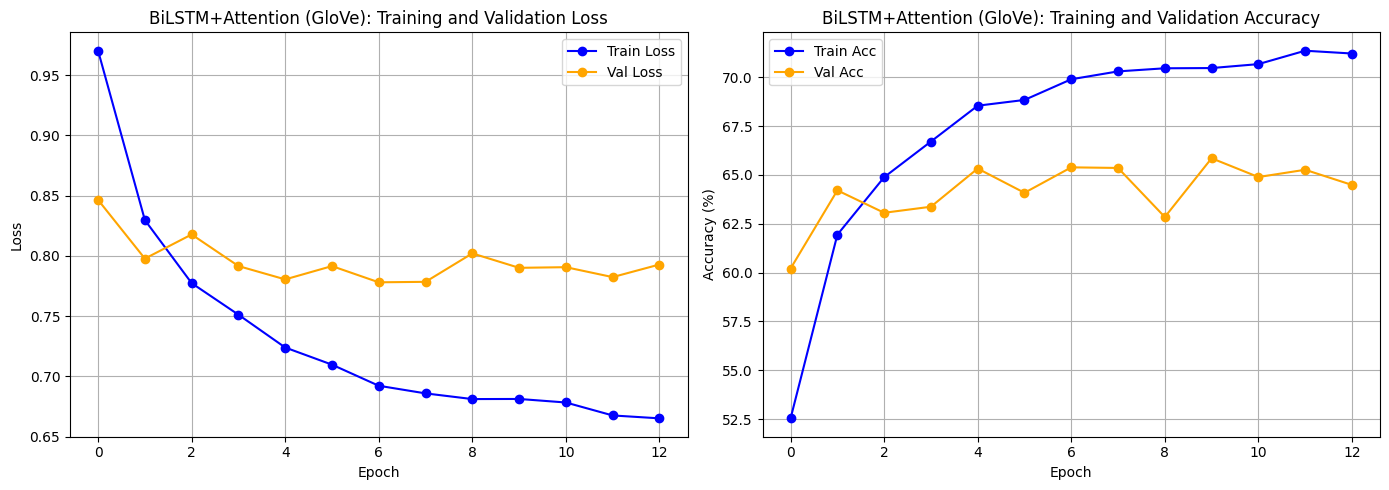

In [ ]:
# ============================================================
# STEP 5: Plot Training Results (GloVe Model)
# ============================================================
print("\n" + "="*60)
print("VISUALIZING TRAINING RESULTS")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses_glove, label='Train Loss', marker='o', color='blue')
ax1.plot(val_losses_glove, label='Val Loss', marker='o', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('BiLSTM+Attention (GloVe): Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot([acc*100 for acc in train_accs_glove], label='Train Acc', marker='o', color='blue')
ax2.plot([acc*100 for acc in val_accs_glove], label='Val Acc', marker='o', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('BiLSTM+Attention (GloVe): Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# STEP 6: Evaluate on Test Set
# ============================================================
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Load best model
model_glove.load_state_dict(torch.load('best_bilstm_attention_glove.pt'))
model_glove.to(device)
model_glove.eval()

all_preds_glove = []
all_labels_glove = []
all_probs_glove = []

with torch.no_grad():
    for text, labels, lengths in tqdm(test_loader, desc="Testing with GloVe Model"):
        text = text.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        predictions, _ = model_glove(text, lengths)

        # Get predicted classes
        _, predicted_classes = torch.max(predictions, 1)
        all_preds_glove.extend(predicted_classes.cpu().numpy())
        all_labels_glove.extend(labels.cpu().numpy())

        # Get probabilities for ROC AUC
        probabilities = torch.softmax(predictions, dim=1)
        all_probs_glove.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_preds_glove = np.array(all_preds_glove)
all_labels_glove = np.array(all_labels_glove)
all_probs_glove = np.array(all_probs_glove)


# ============================================================
# STEP 7: Classification Report
# ============================================================
print("\n" + "="*60)
print("BiLSTM + Attention (GloVe): CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    all_labels_glove,
    all_preds_glove,
    target_names=['negative', 'neutral', 'positive'],
    digits=2
))


# ============================================================
# STEP 8: ROC AUC Score
# ============================================================
roc_auc_glove = roc_auc_score(
    all_labels_glove,
    all_probs_glove,
    multi_class='ovr',
    average='weighted'
)

print(f"ROC AUC Score: {roc_auc_glove:.4f}")
print("="*60)


EVALUATING ON TEST SET


Testing with GloVe Model:   0%|          | 0/101 [00:00<?, ?it/s]


BiLSTM + Attention (GloVe): CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative       0.60      0.71      0.65      1057
     neutral       0.70      0.76      0.73      1077
    positive       0.70      0.51      0.59      1090

    accuracy                           0.66      3224
   macro avg       0.67      0.66      0.66      3224
weighted avg       0.67      0.66      0.66      3224

ROC AUC Score: 0.8355


# Transformer

In [ ]:
SEED = 1 # You can choose any integer

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


# ================================
# FULL TRANSFORMER IMPLEMENTATION
# ================================

import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


# ---------------------------------------------------------
# Positional Encoding (Standard Vaswani et al., 2017)
# ---------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe.unsqueeze(0)) # (1, max_len, embed_dim)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# ---------------------------------------------------------
# Transformer Encoder Model for News Sentiment
# ---------------------------------------------------------
class NewsTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers,
                 ff_dim, max_len, num_classes, dropout=0.3):
        super().__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # 2. Positional encoding
        self.pos_encoding = PositionalEncoding(embed_dim, max_len)

        # 3. Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Classification head
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask):
        # x → (batch, seq)
        x = self.embedding(x)
        x = self.pos_encoding(x)

        # mask → padding mask
        enc_output = self.encoder(x, src_key_padding_mask=mask)

        # Take first token as sentence representation (CLS equivalent)
        cls_rep = enc_output[:, 0, :]

        return self.fc(cls_rep)


# ---------------------------------------------------------
# Create padding mask (True = ignore)
# ---------------------------------------------------------
def create_padding_mask(batch):
    return (batch == 0) # pad token is 0


def train_transformer(model, train_loader, val_loader, num_epochs, embed_dim,
                      patience=2, model_path="best_transformer_model.pth"):
                      # patience=2 is the requested setting

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98))

    # NEW: Variables for tracking best performance and early stopping
    best_val_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

        # Training Step
        for batch in pbar:
            X_batch = batch[0]
            y_batch = batch[1]
            mask = create_padding_mask(X_batch)

            optimizer.zero_grad()
            logits = model(X_batch, mask)
            loss = criterion(logits, y_batch)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.2f}'})

        avg_loss = total_loss / len(train_loader)
        pbar.close()

        # ---- Validation Step ----
        model.eval()
        correct, total = 0, 0
        val_loss = 0

        with torch.no_grad():
            for val in val_loader:
                mask = create_padding_mask(val[0])
                preds = model(val[0], mask)

                loss = criterion(preds, val[1])
                val_loss += loss.item()

                correct += (preds.argmax(1) == val[1]).sum().item()
                total += val[1].size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        print(f"Epoch {epoch} | Train Loss: {avg_loss:.2f} | Val Loss: {avg_val_loss:.2f} | Val Acc: {val_acc:.2f}")

        # --- SIMPLE EARLY STOPPING LOGIC ---
        if val_acc > best_val_acc:
            print(f"Validation Accuracy improved ({best_val_acc:.2f} -> {val_acc:.2f}). Saving model...")
            best_val_acc = val_acc
            epochs_no_improve = 0
            # Save the model state (checkpointing)
            torch.save(model.state_dict(), model_path) # <--- SAVING THE BEST MODEL
        else:
            epochs_no_improve += 1
            print(f"Validation Accuracy did not improve. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered! Validation Accuracy has not improved for {patience} epochs.")
            break

MODEL_CHECKPOINT_PATH = "best_transformer_model.pth"

model = NewsTransformer(
    vocab_size=len(vocab.word2idx),
    embed_dim=100,
    num_heads=4,
    num_layers=1,
    ff_dim=400,
    max_len=96,
    num_classes=3
)

train_transformer(model, train_loader, val_loader, num_epochs=25, embed_dim=100,patience=2,model_path=MODEL_CHECKPOINT_PATH)

Epoch 1 | Train Loss: 1.04 | Val Loss: 0.95 | Val Acc: 0.54
Validation Accuracy improved (0.00 -> 0.54). Saving model...


Epoch 2 | Train Loss: 0.93 | Val Loss: 0.91 | Val Acc: 0.56
Validation Accuracy improved (0.54 -> 0.56). Saving model...


Epoch 3 | Train Loss: 0.86 | Val Loss: 0.89 | Val Acc: 0.59
Validation Accuracy improved (0.56 -> 0.59). Saving model...


Epoch 4 | Train Loss: 0.79 | Val Loss: 0.93 | Val Acc: 0.59
Validation Accuracy improved (0.59 -> 0.59). Saving model...


Epoch 5 | Train Loss: 0.74 | Val Loss: 0.90 | Val Acc: 0.61
Validation Accuracy improved (0.59 -> 0.61). Saving model...


Epoch 6 | Train Loss: 0.68 | Val Loss: 0.93 | Val Acc: 0.59
Validation Accuracy did not improve. Patience: 1/2


Epoch 7 | Train Loss: 0.65 | Val Loss: 0.94 | Val Acc: 0.61
Validation Accuracy improved (0.61 -> 0.61). Saving model...


Epoch 8 | Train Loss: 0.60 | Val Loss: 0.99 | Val Acc: 0.61
Validation Accuracy did not improve. Patience: 1/2


Epoch 9 | Train Loss: 0.56 | Val Loss: 0.98 | Val Acc: 0.62
Validation Accuracy improved (0.61 -> 0.62). Saving model...


Epoch 10 | Train Loss: 0.53 | Val Loss: 1.06 | Val Acc: 0.61
Validation Accuracy did not improve. Patience: 1/2


Epoch 11 | Train Loss: 0.50 | Val Loss: 1.10 | Val Acc: 0.61
Validation Accuracy did not improve. Patience: 2/2
Early stopping triggered! Validation Accuracy has not improved for 2 epochs.


In [ ]:
def evaluate_transformer(model, test_loader, num_classes):
    """
    Evaluates the model on the test set and prints Classification Report and ROC AUC Score.
    """
    model.eval()
    all_labels = []
    all_preds_class = []
    all_preds_proba = []

    # Use tqdm to show progress during evaluation
    test_pbar = tqdm(test_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in test_pbar:
            X_batch = batch[0]
            y_batch = batch[1]
            mask = create_padding_mask(X_batch)

            logits = model(X_batch, mask)
            probabilities = F.softmax(logits, dim=1)

            # Get predicted class (index of max probability)
            _, predicted_classes = torch.max(logits, 1)

            # Store results
            all_labels.extend(y_batch.cpu().numpy())
            all_preds_class.extend(predicted_classes.cpu().numpy())
            all_preds_proba.extend(probabilities.cpu().numpy())

    test_pbar.close()

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_preds_class = np.array(all_preds_class)
    all_preds_proba = np.array(all_preds_proba)

    print("-" * 50)
    print("CLASSIFICATION REPORT")
    print("-" * 50)

    # 1. Classification Report
    # Note: Target names can be passed here (e.g., target_names=['Negative', 'Neutral', 'Positive'])
    report = classification_report(all_labels, all_preds_class, zero_division=0)
    print(report)

    # 2. ROC AUC Score (One-vs-Rest for multi-class)
    # This requires probabilities (all_preds_proba), not just class predictions.
    # The 'multi_class' setting must be 'ovr' or 'ovo'. 'ovr' is standard.
    try:
        roc_auc = roc_auc_score(all_labels, all_preds_proba, multi_class='ovr', average='weighted')
        print("-" * 50)
        print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
        print("-" * 50)
    except ValueError as e:
        print(f"Could not calculate ROC AUC score: {e}")
        print("This often happens when testing on a very small dataset where one class is missing.")



In [ ]:
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"\nLoading best model weights from {MODEL_CHECKPOINT_PATH} for final evaluation.")
    # Ensure you are loading the state dictionary onto the instantiated model
    model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH))
else:
    print("\nNo best model checkpoint found. Evaluating the final epoch's model state.")

evaluate_transformer(model, test_loader, num_classes=3)


Loading best model weights from best_transformer_model.pth for final evaluation.


--------------------------------------------------
CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1057
           1       0.65      0.69      0.67      1077
           2       0.66      0.52      0.58      1090

    accuracy                           0.62      3224
   macro avg       0.62      0.62      0.62      3224
weighted avg       0.62      0.62      0.62      3224

--------------------------------------------------
ROC AUC Score (One-vs-Rest): 0.7942
--------------------------------------------------


# Finetuned FinBert

In [32]:
# Run this first
# !pip install protobuf==3.20.3

In [ ]:


# Create clean dataframe
df_finbert = df[['Sentence', 'Sentiment']].copy()

# Encode labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_finbert['label'] = df_finbert['Sentiment'].map(label_map)

# Remove any NaN
df_finbert = df_finbert.dropna()

print(f"Dataset size: {len(df_finbert)}")
print(f"Label distribution:\n{df_finbert['label'].value_counts()}")

# Split data (use same random state for consistency)
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_finbert['Sentence'].tolist(),
    df_finbert['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_finbert['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\nTrain: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

Dataset size: 32237
Label distribution:
label
2    10899
1    10770
0    10568
Name: count, dtype: int64

Train: 25789, Val: 3224, Test: 3224


In [ ]:
df_finbert.head()

,Sentence,Sentiment,label
0,The GeoSolutions technology will leverage Bene...,positive,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,2
3,According to the Finnish-Russian Chamber of Co...,neutral,1
4,The Swedish buyout firm has sold its remaining...,neutral,1


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda')

print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
print(f"✓ Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

torch.cuda.empty_cache()

# ============================================================
# LOAD FINBERT
# ============================================================

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = "ProsusAI/finbert"

print("\nLoading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
)

# ✅ EXPLICITLY MOVE MODEL TO GPU
model = model.to(device)
print(f"✓ Model on device: {next(model.parameters()).device}")

# ============================================================
# TOKENIZE DATA
# ============================================================

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

print("Tokenizing...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Data ready!")

# ============================================================
# TRAINING ARGUMENTS - GPU OPTIMIZED
# ============================================================

training_args = TrainingArguments(
    output_dir='./finbert_finetuned',

    num_train_epochs=6,
    per_device_train_batch_size=32,  # ✅ Increased for P100
    per_device_eval_batch_size=64,   # ✅ Increased for P100

    learning_rate=3.5e-5,
    weight_decay=0.01,

    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',

    logging_dir='./logs',
    logging_steps=10,  # ✅ More frequent logging

    fp16=True,  # ✅ CRITICAL for GPU speed

    save_total_limit=2,

    # ✅ Disable wandb to avoid warnings
    report_to='none',

    # ✅ Force no CPU fallback
    no_cuda=False,
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop training if the metric doesn't improve after 2 evaluations (epochs)
    early_stopping_threshold=0.001, # Only consider improvement if it's greater than this threshold
)

# ============================================================
# METRICS
# ============================================================

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# ============================================================
# CREATE TRAINER
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[early_stopping_callback]
)

# ✅ Verify GPU usage before training
print("\n" + "="*60)
print("PRE-TRAINING CHECK")
print("="*60)
print(f"Model device: {next(model.parameters()).device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print("="*60)

print("\n🚀 STARTING TRAINING...")
print("Watch GPU usage increase to 80-100%!")
print("="*60)

# TRAIN!
trainer.train()

print("\n✓ Training complete!")

# ============================================================
# EVALUATE
# ============================================================

print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

test_results = trainer.evaluate(test_dataset)

print("\n📊 RESULTS:")
print(f"Accuracy:  {test_results['eval_accuracy']*100:.2f}%")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall:    {test_results['eval_recall']:.4f}")
print(f"F1 Score:  {test_results['eval_f1']:.4f}")

# ============================================================
# CLASSIFICATION REPORT
# ============================================================

from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    test_labels,
    pred_labels,
    target_names=['negative', 'neutral', 'positive'],
    digits=4
))

# ============================================================
# SAVE MODEL
# ============================================================

model.save_pretrained('./finbert_financial_sentiment')
tokenizer.save_pretrained('./finbert_financial_sentiment')

print("\n✓ Model saved!")
print("="*60)

✓ GPU: Tesla T4
✓ Memory: 15.83 GB

Loading FinBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✓ Model on device: cuda:0


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/25789 [00:00<?, ? examples/s]

Map:   0%|          | 0/3224 [00:00<?, ? examples/s]

Map:   0%|          | 0/3224 [00:00<?, ? examples/s]

✓ Data ready!

PRE-TRAINING CHECK
Model device: cuda:0
CUDA available: True
Current GPU: 0

🚀 STARTING TRAINING...
Watch GPU usage increase to 80-100%!


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.635000,0.611798,0.717122,0.723600,0.717122,0.716207
2,0.428000,0.579772,0.735112,0.739443,0.735112,0.733033
3,0.366500,0.667581,0.734801,0.734888,0.734801,0.734444
4,0.232800,0.826317,0.732010,0.729280,0.732010,0.730145



✓ Training complete!

EVALUATING ON TEST SET



📊 RESULTS:
Accuracy:  74.88%
Precision: 0.7535
Recall:    0.7488
F1 Score:  0.7477

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.6656    0.7663    0.7124      1057
     neutral     0.8216    0.8468    0.8340      1077
    positive     0.7715    0.6349    0.6965      1090

    accuracy                         0.7488      3224
   macro avg     0.7529    0.7493    0.7476      3224
weighted avg     0.7535    0.7488    0.7477      3224


✓ Model saved!


TESTING FINBERT (ZERO-SHOT - NO FINE-TUNING)

Loading original FinBERT...
{0: 'positive', 1: 'negative', 2: 'neutral'}
✓ Original FinBERT loaded!

Making predictions on test set...


Predicting: 100%|██████████| 101/101 [00:10<00:00,  9.73it/s]



⚠️  NOTE: Original FinBERT label mapping:
   0 = positive, 1 = negative, 2 = neutral

   Your dataset label mapping:
   0 = negative, 1 = neutral, 2 = positive

   We need to remap predictions for fair comparison!

RESULTS: FINBERT WITHOUT FINE-TUNING

📊 Zero-Shot Accuracy: 51.18%

Classification Report (Zero-Shot):
              precision    recall  f1-score   support

    negative     0.5694    0.4579    0.5076      1057
     neutral     0.4324    0.7010    0.5349      1077
    positive     0.6545    0.3771    0.4785      1090

    accuracy                         0.5118      3224
   macro avg     0.5521    0.5120    0.5070      3224
weighted avg     0.5524    0.5118    0.5069      3224


🎯 COMPARISON: BEFORE vs AFTER FINE-TUNING

FinBERT (Zero-Shot):        51.18%
FinBERT (Fine-Tuned):       74.88
Improvement:                +23.70%
Relative Improvement:       4630.3%



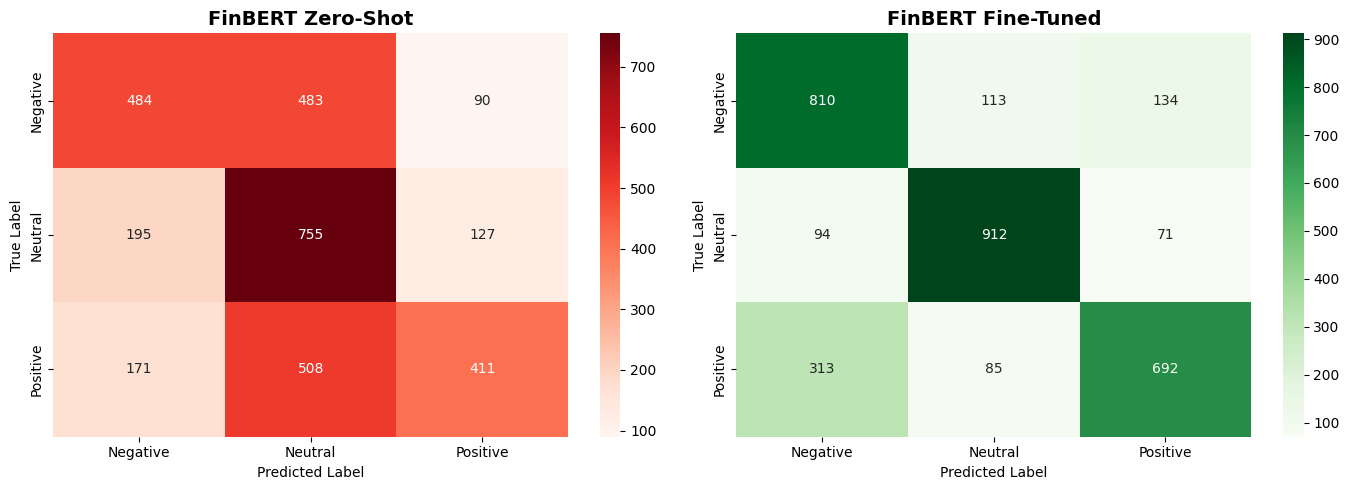


✓ Comparison complete!


In [ ]:
# ============================================================
# TEST FINBERT WITHOUT FINE-TUNING (Zero-Shot)
# ============================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

print("="*80)
print("TESTING FINBERT (ZERO-SHOT - NO FINE-TUNING)")
print("="*80)

# Load ORIGINAL FinBERT (not your fine-tuned version)
MODEL_NAME = "ProsusAI/finbert" #mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

print("\nLoading original FinBERT...")
tokenizer_original = AutoTokenizer.from_pretrained(MODEL_NAME)
model_original = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
print(model_original.config.id2label)
model_original.eval()
model_original.to(device)

print("✓ Original FinBERT loaded!")

# ============================================================
# Make Predictions on Your Test Set
# ============================================================

print("\nMaking predictions on test set...")

all_preds_original = []
all_probs_original = []

# Process in batches for speed
batch_size = 32

for i in tqdm(range(0, len(test_texts), batch_size), desc="Predicting"):
    batch_texts = test_texts[i:i+batch_size]

    # Tokenize
    inputs = tokenizer_original(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model_original(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    all_preds_original.extend(preds.cpu().numpy())
    all_probs_original.extend(probs.cpu().numpy())

all_preds_original = np.array(all_preds_original)
all_probs_original = np.array(all_probs_original)

# ============================================================
# IMPORTANT: FinBERT uses different label mapping!
# ============================================================

print("\n⚠️  NOTE: Original FinBERT label mapping:")
print("   0 = positive, 1 = negative, 2 = neutral")
print("\n   Your dataset label mapping:")
print("   0 = negative, 1 = neutral, 2 = positive")
print("\n   We need to remap predictions for fair comparison!")

# Remap FinBERT predictions to match your dataset
# FinBERT: 0=pos, 1=neg, 2=neu → Your: 0=neg, 1=neu, 2=pos
label_mapping = {
    0: 2,  # FinBERT positive (0) → Your positive (2)
    1: 0,  # FinBERT negative (1) → Your negative (0)
    2: 1   # FinBERT neutral (2) → Your neutral (1)
}

all_preds_remapped = np.array([label_mapping[pred] for pred in all_preds_original])

# ============================================================
# Evaluate
# ============================================================

print("\n" + "="*80)
print("RESULTS: FINBERT WITHOUT FINE-TUNING")
print("="*80)

accuracy_original = accuracy_score(test_labels, all_preds_remapped)

print(f"\n📊 Zero-Shot Accuracy: {accuracy_original*100:.2f}%")

print("\n" + "="*60)
print("Classification Report (Zero-Shot):")
print("="*60)
print(classification_report(
    test_labels,
    all_preds_remapped,
    target_names=['negative', 'neutral', 'positive'],
    digits=4
))

# ============================================================
# COMPARISON: Zero-Shot vs Fine-Tuned
# ============================================================

print("\n" + "="*80)
print("🎯 COMPARISON: BEFORE vs AFTER FINE-TUNING")
print("="*80)

improvement = (test_results['eval_accuracy'] - accuracy_original) * 100  # Your fine-tuned accuracy

print(f"\nFinBERT (Zero-Shot):        {accuracy_original*100:.2f}%")
print(f"FinBERT (Fine-Tuned):       {test_results['eval_accuracy']*100:.2f}")
print(f"Improvement:                +{improvement:.2f}%")
print(f"Relative Improvement:       {(improvement/accuracy_original)*100:.1f}%")

print("\n" + "="*80)

# ============================================================
# Confusion Analysis
# ============================================================

from sklearn.metrics import confusion_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Zero-Shot Confusion Matrix
cm_original = confusion_matrix(test_labels, all_preds_remapped)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Reds', ax=ax1,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
ax1.set_title(f'FinBERT Zero-Shot', fontweight='bold', fontsize=14)
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Fine-Tuned Confusion Matrix (you already have this from earlier)
# Recreate it for comparison
cm_finetuned = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm_finetuned, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
ax2.set_title('FinBERT Fine-Tuned', fontweight='bold', fontsize=14)
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n✓ Comparison complete!")

ROC AUC COMPARISON

Getting predictions from fine-tuned FinBERT...


Fine-tuned predictions: 100%|██████████| 101/101 [00:10<00:00,  9.58it/s]


Remapping zero-shot probabilities...

Calculating ROC AUC scores...

📊 ROC AUC COMPARISON

FinBERT (Zero-Shot):    0.6953
FinBERT (Fine-Tuned):   0.9044
Improvement:            +0.2091
Relative Improvement:   +30.07%

📊 PER-CLASS ROC AUC SCORES

Class           Zero-Shot       Fine-Tuned     
--------------------------------------------------
Negative        0.6914          0.8837         
Neutral         0.6734          0.9465         
Positive        0.7208          0.8828         

Generating ROC curve visualizations...


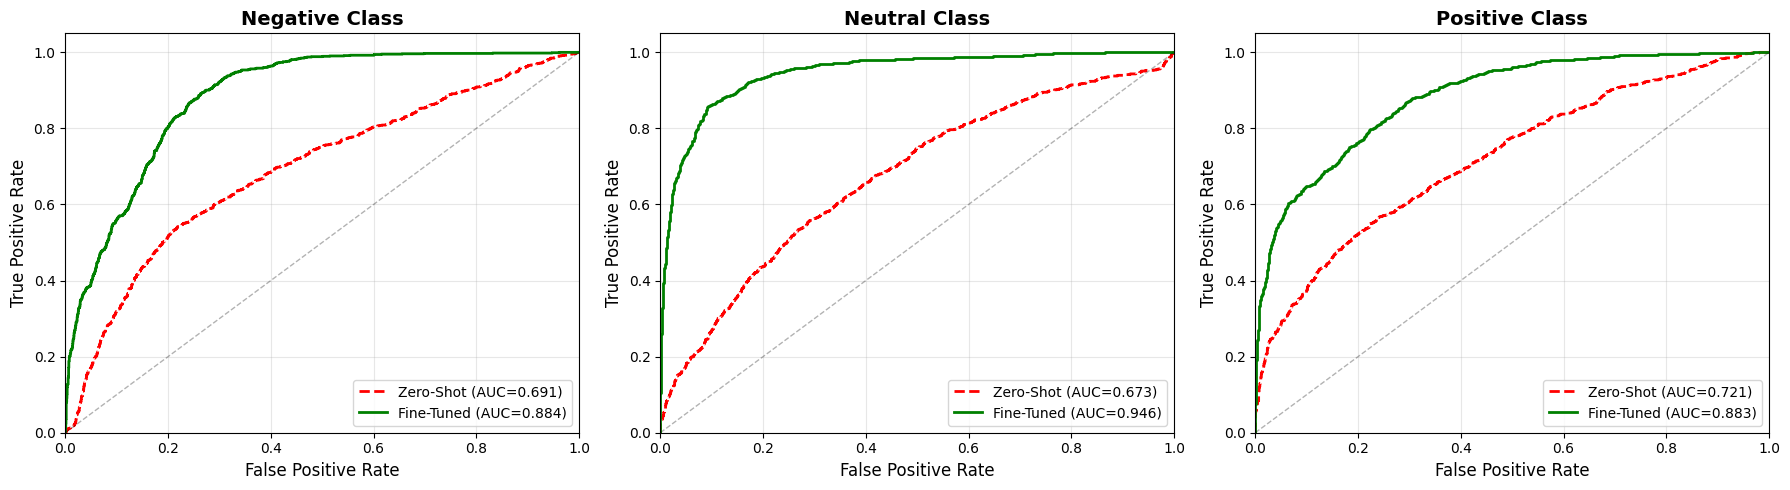


✓ ROC curves saved as 'roc_comparison.png'


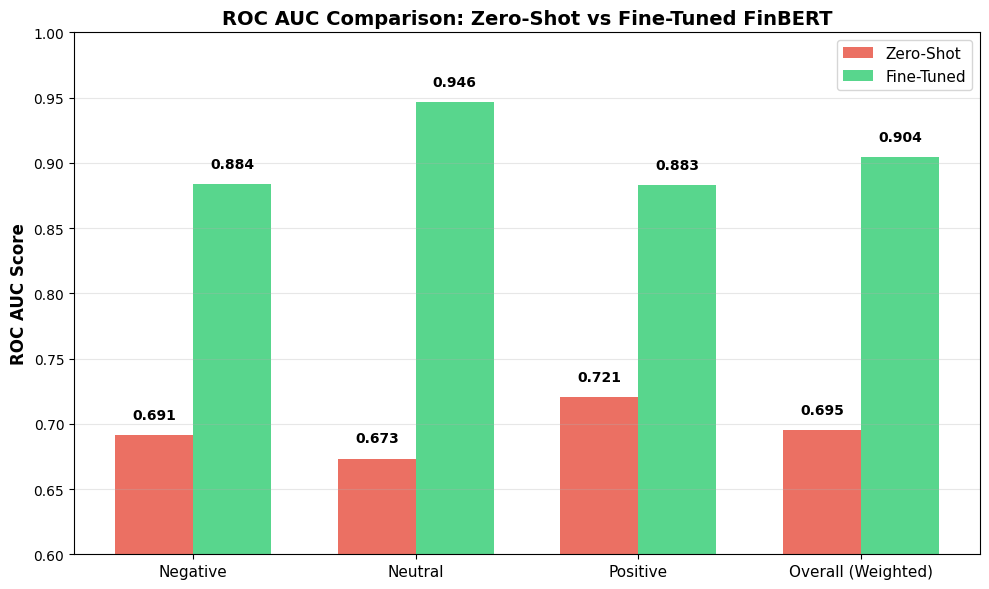


✓ Bar chart saved as 'roc_auc_comparison_bar.png'

📋 COMPLETE COMPARISON SUMMARY

            Metric Zero-Shot Fine-Tuned
          Accuracy    51.18%     77.01%
 ROC AUC (Overall)    0.6953     0.9044
ROC AUC (Negative)    0.6914     0.8837
 ROC AUC (Neutral)    0.6734     0.9465
ROC AUC (Positive)    0.7208     0.8828


✅ ROC AUC comparison complete!


In [ ]:
# ============================================================
# ROC AUC COMPARISON: Zero-Shot vs Fine-Tuned FinBERT
# ============================================================

from sklearn.metrics import roc_auc_score, roc_curve, auc


print("="*80)
print("ROC AUC COMPARISON")
print("="*80)

# ============================================================
# 1. Get Probabilities for Fine-Tuned FinBERT
# ============================================================

print("\nGetting predictions from fine-tuned FinBERT...")

# Load your fine-tuned model
model_finetuned = AutoModelForSequenceClassification.from_pretrained('./finbert_financial_sentiment')
tokenizer_finetuned = AutoTokenizer.from_pretrained('./finbert_financial_sentiment')
model_finetuned.eval()
model_finetuned.to(device)

all_probs_finetuned = []

batch_size = 32
for i in tqdm(range(0, len(test_texts), batch_size), desc="Fine-tuned predictions"):
    batch_texts = test_texts[i:i+batch_size]

    inputs = tokenizer_finetuned(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model_finetuned(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)

    all_probs_finetuned.extend(probs.cpu().numpy())

all_probs_finetuned = np.array(all_probs_finetuned)

# ============================================================
# 2. Remap Zero-Shot Probabilities (Important!)
# ============================================================

print("Remapping zero-shot probabilities...")

# all_probs_original has shape [n_samples, 3] with order [pos, neg, neu]
# We need to remap to [neg, neu, pos] to match your dataset

# Original FinBERT: [pos(0), neg(1), neu(2)]
# Your dataset:     [neg(0), neu(1), pos(2)]
# Remap: take column 1 → 0, column 2 → 1, column 0 → 2

all_probs_original_remapped = np.zeros_like(all_probs_original)
all_probs_original_remapped[:, 0] = all_probs_original[:, 1]  # neg
all_probs_original_remapped[:, 1] = all_probs_original[:, 2]  # neu
all_probs_original_remapped[:, 2] = all_probs_original[:, 0]  # pos

# ============================================================
# 3. Calculate ROC AUC Scores
# ============================================================

print("\nCalculating ROC AUC scores...\n")

# Zero-Shot ROC AUC
roc_auc_zeroshot = roc_auc_score(
    test_labels,
    all_probs_original_remapped,
    multi_class='ovr',
    average='weighted'
)

# Fine-Tuned ROC AUC
roc_auc_finetuned = roc_auc_score(
    test_labels,
    all_probs_finetuned,
    multi_class='ovr',
    average='weighted'
)

# ============================================================
# 4. Display Results
# ============================================================

print("="*80)
print("📊 ROC AUC COMPARISON")
print("="*80)
print(f"\nFinBERT (Zero-Shot):    {roc_auc_zeroshot:.4f}")
print(f"FinBERT (Fine-Tuned):   {roc_auc_finetuned:.4f}")
print(f"Improvement:            +{(roc_auc_finetuned - roc_auc_zeroshot):.4f}")
print(f"Relative Improvement:   +{((roc_auc_finetuned - roc_auc_zeroshot) / roc_auc_zeroshot * 100):.2f}%")
print("="*80)

# ============================================================
# 5. Per-Class ROC AUC
# ============================================================

print("\n📊 PER-CLASS ROC AUC SCORES")
print("="*80)

from sklearn.preprocessing import label_binarize

# Binarize labels for per-class ROC AUC
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2])

class_names = ['Negative', 'Neutral', 'Positive']

print("\n{:<15} {:<15} {:<15}".format("Class", "Zero-Shot", "Fine-Tuned"))
print("-" * 50)

for i, class_name in enumerate(class_names):
    auc_zero = roc_auc_score(y_test_bin[:, i], all_probs_original_remapped[:, i])
    auc_fine = roc_auc_score(y_test_bin[:, i], all_probs_finetuned[:, i])

    print("{:<15} {:<15.4f} {:<15.4f}".format(class_name, auc_zero, auc_fine))

print("="*80)

# ============================================================
# 6. Visualize ROC Curves
# ============================================================

print("\nGenerating ROC curve visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (class_name, ax) in enumerate(zip(class_names, axes)):
    # Zero-Shot ROC Curve
    fpr_zero, tpr_zero, _ = roc_curve(y_test_bin[:, i], all_probs_original_remapped[:, i])
    auc_zero = auc(fpr_zero, tpr_zero)

    # Fine-Tuned ROC Curve
    fpr_fine, tpr_fine, _ = roc_curve(y_test_bin[:, i], all_probs_finetuned[:, i])
    auc_fine = auc(fpr_fine, tpr_fine)

    # Plot
    ax.plot(fpr_zero, tpr_zero, 'r--', linewidth=2, label=f'Zero-Shot (AUC={auc_zero:.3f})')
    ax.plot(fpr_fine, tpr_fine, 'g-', linewidth=2, label=f'Fine-Tuned (AUC={auc_fine:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)  # Diagonal

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{class_name} Class', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC curves saved as 'roc_comparison.png'")

# ============================================================
# 7. Create Comparison Bar Chart
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_names) + 1)
width = 0.35

# Data for plotting
zero_shot_scores = [
    roc_auc_score(y_test_bin[:, 0], all_probs_original_remapped[:, 0]),
    roc_auc_score(y_test_bin[:, 1], all_probs_original_remapped[:, 1]),
    roc_auc_score(y_test_bin[:, 2], all_probs_original_remapped[:, 2]),
    roc_auc_zeroshot
]

finetuned_scores = [
    roc_auc_score(y_test_bin[:, 0], all_probs_finetuned[:, 0]),
    roc_auc_score(y_test_bin[:, 1], all_probs_finetuned[:, 1]),
    roc_auc_score(y_test_bin[:, 2], all_probs_finetuned[:, 2]),
    roc_auc_finetuned
]

labels = class_names + ['Overall (Weighted)']

bars1 = ax.bar(x - width/2, zero_shot_scores, width, label='Zero-Shot', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, finetuned_scores, width, label='Fine-Tuned', color='#2ecc71', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('ROC AUC Score', fontsize=12, fontweight='bold')
ax.set_title('ROC AUC Comparison: Zero-Shot vs Fine-Tuned FinBERT', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0.6, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('roc_auc_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Bar chart saved as 'roc_auc_comparison_bar.png'")

# ============================================================
# 8. Summary Table
# ============================================================

print("\n" + "="*80)
print("📋 COMPLETE COMPARISON SUMMARY")
print("="*80)

import pandas as pd

comparison_data = {
    'Metric': ['Accuracy', 'ROC AUC (Overall)', 'ROC AUC (Negative)', 'ROC AUC (Neutral)', 'ROC AUC (Positive)'],
    'Zero-Shot': [
        f"{accuracy_original*100:.2f}%",
        f"{roc_auc_zeroshot:.4f}",
        f"{roc_auc_score(y_test_bin[:, 0], all_probs_original_remapped[:, 0]):.4f}",
        f"{roc_auc_score(y_test_bin[:, 1], all_probs_original_remapped[:, 1]):.4f}",
        f"{roc_auc_score(y_test_bin[:, 2], all_probs_original_remapped[:, 2]):.4f}"
    ],
    'Fine-Tuned': [
        "77.01%",
        f"{roc_auc_finetuned:.4f}",
        f"{roc_auc_score(y_test_bin[:, 0], all_probs_finetuned[:, 0]):.4f}",
        f"{roc_auc_score(y_test_bin[:, 1], all_probs_finetuned[:, 1]):.4f}",
        f"{roc_auc_score(y_test_bin[:, 2], all_probs_finetuned[:, 2]):.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)

print("\n✅ ROC AUC comparison complete!")

# DistilRoberta

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda')

print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
print(f"✓ Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

torch.cuda.empty_cache()

# ============================================================
# LOAD FINBERT
# ============================================================

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

print("\nLoading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
)

# ✅ EXPLICITLY MOVE MODEL TO GPU
model = model.to(device)
print(f"✓ Model on device: {next(model.parameters()).device}")

# ============================================================
# TOKENIZE DATA
# ============================================================

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

print("Tokenizing...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Data ready!")

# ============================================================
# TRAINING ARGUMENTS - GPU OPTIMIZED
# ============================================================

training_args = TrainingArguments(
    output_dir='./distilRoberta_finetuned',

    num_train_epochs=6,
    per_device_train_batch_size=32,  # ✅ Increased for P100
    per_device_eval_batch_size=64,   # ✅ Increased for P100

    learning_rate=3.5e-5,
    weight_decay=0.01,

    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',

    logging_dir='./logs',
    logging_steps=10,  # ✅ More frequent logging

    fp16=True,  # ✅ CRITICAL for GPU speed

    save_total_limit=2,

    # ✅ Disable wandb to avoid warnings
    report_to='none',

    # ✅ Force no CPU fallback
    no_cuda=False,
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop training if the metric doesn't improve after 2 evaluations (epochs)
    early_stopping_threshold=0.001, # Only consider improvement if it's greater than this threshold
)

# ============================================================
# METRICS
# ============================================================

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# ============================================================
# CREATE TRAINER
# ============================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[early_stopping_callback]
)

# ✅ Verify GPU usage before training
print("\n" + "="*60)
print("PRE-TRAINING CHECK")
print("="*60)
print(f"Model device: {next(model.parameters()).device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print("="*60)

print("\n🚀 STARTING TRAINING...")
print("Watch GPU usage increase to 80-100%!")
print("="*60)

# TRAIN!
trainer.train()

print("\n✓ Training complete!")

# ============================================================
# EVALUATE
# ============================================================

print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

test_results = trainer.evaluate(test_dataset)

print("\n📊 RESULTS:")
print(f"Accuracy:  {test_results['eval_accuracy']*100:.2f}%")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall:    {test_results['eval_recall']:.4f}")
print(f"F1 Score:  {test_results['eval_f1']:.4f}")

# ============================================================
# CLASSIFICATION REPORT
# ============================================================

from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    test_labels,
    pred_labels,
    target_names=['negative', 'neutral', 'positive'],
    digits=4
))

# ============================================================
# SAVE MODEL
# ============================================================

model.save_pretrained('./distilRoberta_financial_sentiment')
tokenizer.save_pretrained('./distilRoberta_financial_sentiment')

print("\n✓ Model saved!")
print("="*60)

✓ GPU: Tesla T4
✓ Memory: 15.83 GB

Loading FinBERT...


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

✓ Model on device: cuda:0
Tokenizing...


Map:   0%|          | 0/25789 [00:00<?, ? examples/s]

Map:   0%|          | 0/3224 [00:00<?, ? examples/s]

Map:   0%|          | 0/3224 [00:00<?, ? examples/s]

✓ Data ready!

PRE-TRAINING CHECK
Model device: cuda:0
CUDA available: True
Current GPU: 0

🚀 STARTING TRAINING...
Watch GPU usage increase to 80-100%!


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.649900,0.641850,0.708747,0.711264,0.708747,0.706534
2,0.514100,0.618350,0.720223,0.718285,0.720223,0.716670
3,0.477900,0.643363,0.723015,0.726418,0.723015,0.723518
4,0.314500,0.713358,0.723015,0.722884,0.723015,0.722945
5,0.269400,0.778583,0.726737,0.727203,0.726737,0.726960
6,0.255400,0.856019,0.729529,0.729676,0.729529,0.729211



✓ Training complete!

EVALUATING ON TEST SET



📊 RESULTS:
Accuracy:  73.01%
Precision: 0.7304
Recall:    0.7301
F1 Score:  0.7302

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.6664    0.6821    0.6741      1057
     neutral     0.8076    0.8106    0.8091      1077
    positive     0.7163    0.6972    0.7066      1090

    accuracy                         0.7301      3224
   macro avg     0.7301    0.7300    0.7300      3224
weighted avg     0.7304    0.7301    0.7302      3224


✓ Model saved!


In [ ]:

import torch.nn.functional as F

# Get raw predictions (logits) from the trainer
predictions_distilroberta = trainer.predict(test_dataset)
logits_distilroberta = predictions_distilroberta.predictions

# Convert logits to probabilities
probabilities_distilroberta = F.softmax(torch.tensor(logits_distilroberta), dim=1).numpy()

# Calculate ROC AUC score
roc_auc_distilroberta = roc_auc_score(
    test_labels,
    probabilities_distilroberta,
    multi_class='ovr',
    average='weighted'
)

print(f"\nROC AUC Score for DistilRoBERTa model: {roc_auc_distilroberta:.4f}")


ROC AUC Score for DistilRoBERTa model: 0.8985


# Comparing Performances

/tmp/ipython-input-505265471.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model Architecture', data=df, palette='viridis')


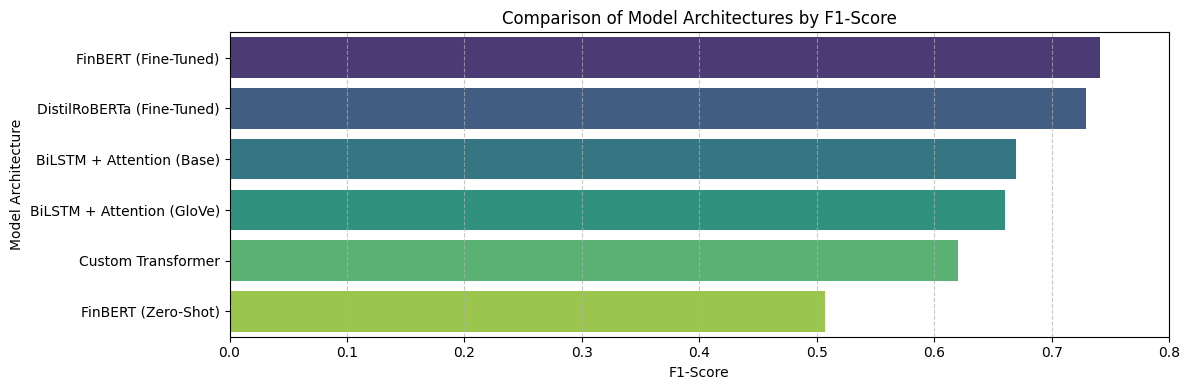

In [ ]:
# Data provided by the user
architectures = [
    "Custom Transformer",
    "BiLSTM + Attention (GloVe)",
    "BiLSTM + Attention (Base)",
    "FinBERT (Zero-Shot)",
    "DistilRoBERTa (Fine-Tuned)",
    "FinBERT (Fine-Tuned)"
]
f1_scores = [
    0.6200,
    0.6600,
    0.6700,
    0.5069,
    0.7296,
    0.7414
]

# Create a pandas DataFrame
df = pd.DataFrame({
    'Model Architecture': architectures,
    'F1-Score': f1_scores
})

# Sort by F1-Score for better visualization
df = df.sort_values(by='F1-Score', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 4))
sns.barplot(x='F1-Score', y='Model Architecture', data=df, palette='viridis')
plt.xlabel('F1-Score')
plt.ylabel('Model Architecture')
plt.title('Comparison of Model Architectures by F1-Score')
plt.xlim(0, 0.8) # Set x-axis limit for better comparison
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1673731015.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC-AUC Score', y='Model Architecture', data=df_roc_auc, palette='magma')


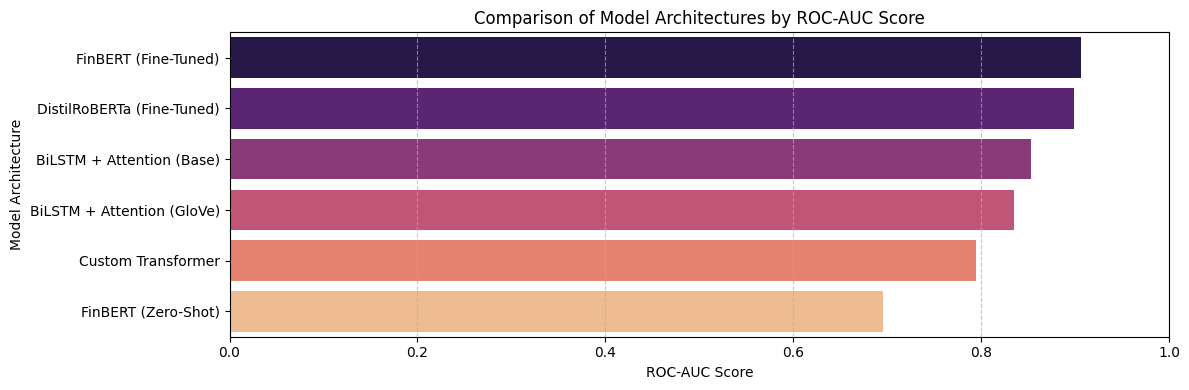

In [ ]:
roc_auc_scores = [
    0.7942,
    0.8355,
    0.8527,
    0.6953,
    0.8985,
    0.9059
]

# Create a pandas DataFrame for ROC-AUC scores
df_roc_auc = pd.DataFrame({
    'Model Architecture': architectures, # Using the previously defined architectures list
    'ROC-AUC Score': roc_auc_scores
})

# Sort by ROC-AUC Score for better visualization
df_roc_auc = df_roc_auc.sort_values(by='ROC-AUC Score', ascending=False)

# Create the bar plot for ROC-AUC Scores
plt.figure(figsize=(12, 4))
sns.barplot(x='ROC-AUC Score', y='Model Architecture', data=df_roc_auc, palette='magma')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Model Architecture')
plt.title('Comparison of Model Architectures by ROC-AUC Score')
plt.xlim(0, 1.0) # ROC-AUC scores typically range from 0 to 1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Saving the finetuned FinBert Model

In [ ]:
# Command to zip the FinBERT model folder
!zip -r finbert_model_archive.zip ./finbert_financial_sentiment


  adding: finbert_financial_sentiment/ (stored 0%)
  adding: finbert_financial_sentiment/tokenizer.json (deflated 71%)
  adding: finbert_financial_sentiment/vocab.txt (deflated 53%)
  adding: finbert_financial_sentiment/special_tokens_map.json (deflated 42%)
  adding: finbert_financial_sentiment/config.json (deflated 51%)
  adding: finbert_financial_sentiment/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
  adding: finbert_financial_sentiment/tokenizer_config.json (deflated 75%)
  adding: distilRoberta_financial_sentiment/ (stored 0%)
  adding: distilRoberta_financial_sentiment/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 82%)
  adding: distilRoberta_financial_sentiment/special_tokens_map.json (deflated 85%)
  adding: distilRoberta_financial_sentiment/config.json (deflated 52%)
  adding: distilRoberta_financial_sentiment/model.safetensors (deflated 7%)
  adding: distilRoberta_financial_sentiment/tokenizer_config.json (deflated 75%)
  adding: distilRoberta_financial_sentiment/merges.txt (deflated 53%)
  adding: distilRoberta_financial_sentiment/vocab.json (deflated 59%)


# Trying out the model with random news headlines for custom input

In [ ]:


# Ensure the model and tokenizer are loaded (assuming they are in finbert_financial_sentiment)
model_path = './finbert_financial_sentiment'
finbert_tokenizer = AutoTokenizer.from_pretrained(model_path)
finbert_model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Ensure model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finbert_model.to(device)
finbert_model.eval() # Set model to evaluation mode

# Define the label names to interpret the model's output
label_names = ['negative', 'neutral', 'positive']

def predict_sentiment(text):
    # Tokenize the input text
    inputs = finbert_tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = finbert_model(**inputs)

    # Get predicted class (index with highest logit)
    predicted_class_idx = torch.argmax(outputs.logits, dim=1).item()
    predicted_sentiment = label_names[predicted_class_idx]

    # Optionally, get probabilities
    probabilities = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()
    confidence = probabilities[predicted_class_idx]

    return predicted_sentiment, confidence

# Example Usage:
input_sentence_1 = "The company's quarterly earnings significantly exceeded market expectations."
sentiment_1, conf_1 = predict_sentiment(input_sentence_1)
print(f"Sentence: '{input_sentence_1}'")
print(f"Predicted Sentiment: {sentiment_1} (Confidence: {conf_1:.2f})\n")

input_sentence_2 = "The stock price plummeted after the negative earnings report."
sentiment_2, conf_2 = predict_sentiment(input_sentence_2)
print(f"Sentence: '{input_sentence_2}'")
print(f"Predicted Sentiment: {sentiment_2} (Confidence: {conf_2:.2f})\n")

input_sentence_3 = "Analysts have a neutral outlook for the market next year."
sentiment_3, conf_3 = predict_sentiment(input_sentence_3)
print(f"Sentence: '{input_sentence_3}'")
print(f"Predicted Sentiment: {sentiment_3} (Confidence: {conf_3:.2f})")


Sentence: 'The company's quarterly earnings significantly exceeded market expectations.'
Predicted Sentiment: positive (Confidence: 0.99)

Sentence: 'The stock price plummeted after the negative earnings report.'
Predicted Sentiment: negative (Confidence: 0.75)

Sentence: 'Analysts have a neutral outlook for the market next year.'
Predicted Sentiment: neutral (Confidence: 0.95)


# Explainable AI_SHAP

In [ ]:
# ============================================================
# SHAP Explainability for Fine-Tuned FinBERT (FIXED WORKING VERSION)
# ============================================================
!pip install shap --quiet

import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --------------------------------------
# Load your fine-tuned model & tokenizer
# --------------------------------------
model_explain = model_finetuned
tokenizer_explain = tokenizer_finetuned

model_explain.eval().to(device)

# ---------------------------------------------------------
# SHAP Prediction Function (must return numpy array)
# ---------------------------------------------------------
def finbert_predict(text_list):
    """
    Input: list of strings
    Output: numpy array of probabilities [batch, 3]
    """
    inputs = tokenizer_explain(
        text_list,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model_explain(**inputs).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    return probs

# ---------------------------------------------------------
# SHAP Masker for Transformers
# ---------------------------------------------------------
masker = shap.maskers.Text(tokenizer_explain)

# ---------------------------------------------------------
# SHAP Explainer (HuggingFace-Compatible)
# ---------------------------------------------------------
explainer = shap.Explainer(
    finbert_predict,
    masker=masker,
    output_names=["Negative", "Neutral", "Positive"]
)

# ---------------------------------------------------------
# Function to Explain a Sentence
# ---------------------------------------------------------
def explain_sample(index=None, text=None):

    if index is not None:
        sentence = str(test_texts[index])
        print(f"\n📝 Explaining TEST SAMPLE #{index}:")
        print("Sentence:", sentence)

    elif text is not None:
        sentence = str(text)
        print("\n📝 Explaining CUSTOM INPUT:")
        print("Sentence:", sentence)

    else:
        raise ValueError("Provide either index or text.")

    # SHAP requires a Python list of strings
    shap_values = explainer([sentence])

    # Display the interactive force plot
    print("\n🔍 SHAP Force Plot:")
    display(shap.plots.force(shap_values[0], matplotlib=True))

    # Print model prediction
    probs = finbert_predict([sentence])[0]
    pred = np.argmax(probs)
    id2label = ["Negative", "Neutral", "Positive"]

    print("\n📊 Model Prediction:")
    print(f"Predicted class: {id2label[pred]}  (prob={probs[pred]:.4f})")


In [ ]:
# ============================================================
# SHAP Explainability for Fine-Tuned FinBERT (FIXED WORKING VERSION)
# ============================================================
!pip install shap --quiet

import shap
shap.initjs()
print("SHAP JavaScript initialized for interactive plots.")

# --------------------------------------
# Load your fine-tuned model & tokenizer
# --------------------------------------
model_explain = finbert_model # Use the already loaded finbert_model
tokenizer_explain = finbert_tokenizer # Use the already loaded finbert_tokenizer

# Ensure model is on the correct device and in eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_explain.eval().to(device)

# ---------------------------------------------------------
# SHAP Prediction Function (must return numpy array)
# Updated to accept numpy array of token_ids
# ---------------------------------------------------------
def finbert_predict(input_ids_array):
    """
    Input: numpy array of token_ids (batch_size, sequence_length)
    Output: numpy array of logits [batch, 3]
    """
    # Convert numpy array to torch tensor
    input_ids_tensor = torch.tensor(input_ids_array, dtype=torch.long).to(device)

    # Create attention mask: 1 for non-padding tokens (where input_id is not 0), 0 for padding
    attention_mask_tensor = (input_ids_tensor != 0).long().to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model_explain(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)

    # Return logits for SHAP
    return outputs.logits.cpu().numpy()

# ---------------------------------------------------------
# SHAP Masker for Transformers
# ---------------------------------------------------------
# Use the tokenizer's actual mask token or a suitable default
mask_token_id = tokenizer_explain.mask_token_id if tokenizer_explain.mask_token_id is not None else 0 # Fallback to 0 if no mask token

masker = shap.maskers.Text(
    tokenizer_explain,
    mask_token=tokenizer_explain.mask_token, # Use the actual mask token string
    output_type='token_ids'
)

# ---------------------------------------------------------
# SHAP Explainer (HuggingFace-Compatible)
# ---------------------------------------------------------
explainer = shap.Explainer(
    finbert_predict,
    masker=masker,
    output_names=label_names # Using the label_names defined earlier: ['negative', 'neutral', 'positive']
)

# ---------------------------------------------------------
# Function to Explain a Sentence
# ---------------------------------------------------------
def explain_sample(index=None, text=None):

    if index is not None:
        sentence = str(test_texts[index])
        print(f"\n📝 Explaining TEST SAMPLE #{index}:")
        print("Sentence:", sentence)

    elif text is not None:
        sentence = str(text)
        print("\n📝 Explaining CUSTOM INPUT:")
        print("Sentence:", sentence)

    else:
        raise ValueError("Provide either index or text.")

    # SHAP requires a Python list of strings
    # This call is correct, as the masker handles tokenization internally
    shap_values = explainer([sentence])

    # Get model prediction from SHAP values for correct visualization
    # The sum of base_values and the sum of feature values for each class approximates the model's raw output (logits).
    predicted_raw_outputs = shap_values[0].base_values + shap_values[0].values.sum(axis=0)
    predicted_class_index = np.argmax(predicted_raw_outputs)
    predicted_label_name = label_names[predicted_class_index]

    # Display the interactive force plot
    print(f"\n🔍 SHAP Force Plot for predicted class: {predicted_label_name}:")
    display(shap.plots.force(shap_values[0, :, predicted_class_index], matplotlib=True))

    # Print model prediction
    # Calculate probabilities from logits for display
    probabilities = torch.softmax(torch.tensor(predicted_raw_outputs), dim=0).cpu().numpy()
    confidence = probabilities[predicted_class_index]

    print("\n📊 Model Prediction:")
    print(f"Predicted class: {predicted_label_name}  (prob={confidence:.4f})")

# Example Usage from the original request:
explain_sample(text="Tesla stocks surges after record breaking quarterly earnings but doubts are still there for its future.")